# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

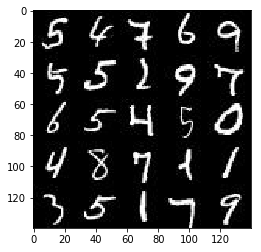

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

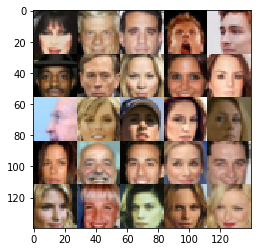

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    z_input = tf.placeholder(tf.float32, [None, z_dim])
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2

        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train

    with tf.variable_scope('generator', reuse=reuse):
        alpha = 0.2

        l1 = tf.layers.dense(z, 7*7*512)
        l1 = tf.reshape(l1, (-1, 7, 7, 512))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(alpha * l1, l1)
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 5, strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(alpha * l2, l2)
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5, strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(alpha * l3, l3)

        logits = tf.layers.conv2d_transpose(l3, out_channel_dim, 5, strides=1, padding='same')

        return tf.tanh(logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_model_real)
        )
    )

    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_model_fake)
        )
    )

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_model_fake)
        )
    )

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    shape = data_shape
    real_input, z_input, lr = model_inputs(shape[1], shape[2], shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0

            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={
                    real_input: batch_images,
                    z_input: batch_z,
                    lr: learning_rate
                })

                _ = sess.run(g_opt, feed_dict={
                    real_input: batch_images,
                    z_input: batch_z,
                    lr: learning_rate
                })

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({real_input: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({z_input: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, z_input, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.5609... Generator Loss: 1.0569
Epoch 1/2... Batch 20... Discriminator Loss: 0.0860... Generator Loss: 3.0831
Epoch 1/2... Batch 30... Discriminator Loss: 0.0287... Generator Loss: 4.7889
Epoch 1/2... Batch 40... Discriminator Loss: 0.2878... Generator Loss: 2.2529
Epoch 1/2... Batch 50... Discriminator Loss: 5.0888... Generator Loss: 0.0252
Epoch 1/2... Batch 60... Discriminator Loss: 0.2262... Generator Loss: 2.6230
Epoch 1/2... Batch 70... Discriminator Loss: 1.3492... Generator Loss: 0.7912
Epoch 1/2... Batch 80... Discriminator Loss: 0.8036... Generator Loss: 1.5196
Epoch 1/2... Batch 90... Discriminator Loss: 1.1355... Generator Loss: 0.9532
Epoch 1/2... Batch 100... Discriminator Loss: 1.1926... Generator Loss: 0.8892


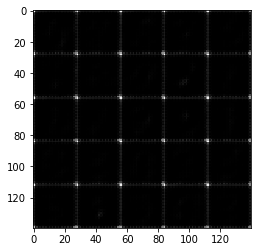

Epoch 1/2... Batch 110... Discriminator Loss: 1.0613... Generator Loss: 0.8844
Epoch 1/2... Batch 120... Discriminator Loss: 1.0186... Generator Loss: 1.2438
Epoch 1/2... Batch 130... Discriminator Loss: 1.5798... Generator Loss: 0.3409
Epoch 1/2... Batch 140... Discriminator Loss: 1.7054... Generator Loss: 0.3285
Epoch 1/2... Batch 150... Discriminator Loss: 1.1474... Generator Loss: 0.5984
Epoch 1/2... Batch 160... Discriminator Loss: 1.1550... Generator Loss: 0.6459
Epoch 1/2... Batch 170... Discriminator Loss: 1.1405... Generator Loss: 0.7846
Epoch 1/2... Batch 180... Discriminator Loss: 1.0778... Generator Loss: 0.8991
Epoch 1/2... Batch 190... Discriminator Loss: 1.2389... Generator Loss: 0.6201
Epoch 1/2... Batch 200... Discriminator Loss: 1.2045... Generator Loss: 1.4603


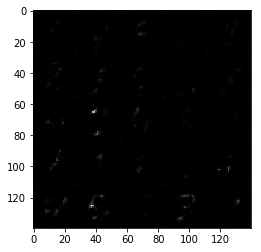

Epoch 1/2... Batch 210... Discriminator Loss: 1.3478... Generator Loss: 0.6308
Epoch 1/2... Batch 220... Discriminator Loss: 1.3537... Generator Loss: 0.4046
Epoch 1/2... Batch 230... Discriminator Loss: 0.8769... Generator Loss: 1.2381
Epoch 1/2... Batch 240... Discriminator Loss: 0.8088... Generator Loss: 1.0243
Epoch 1/2... Batch 250... Discriminator Loss: 0.9071... Generator Loss: 0.9834
Epoch 1/2... Batch 260... Discriminator Loss: 0.8877... Generator Loss: 0.8403
Epoch 1/2... Batch 270... Discriminator Loss: 1.2577... Generator Loss: 1.8889
Epoch 1/2... Batch 280... Discriminator Loss: 0.9454... Generator Loss: 1.0783
Epoch 1/2... Batch 290... Discriminator Loss: 1.0578... Generator Loss: 0.7909
Epoch 1/2... Batch 300... Discriminator Loss: 1.2791... Generator Loss: 0.4912


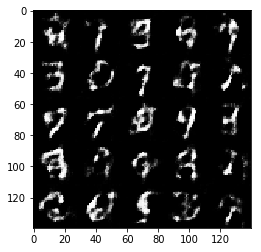

Epoch 1/2... Batch 310... Discriminator Loss: 0.9219... Generator Loss: 1.5182
Epoch 1/2... Batch 320... Discriminator Loss: 1.0709... Generator Loss: 1.9315
Epoch 1/2... Batch 330... Discriminator Loss: 1.0644... Generator Loss: 0.5978
Epoch 1/2... Batch 340... Discriminator Loss: 1.2238... Generator Loss: 1.2072
Epoch 1/2... Batch 350... Discriminator Loss: 1.2937... Generator Loss: 0.5074
Epoch 1/2... Batch 360... Discriminator Loss: 1.0713... Generator Loss: 0.9159
Epoch 1/2... Batch 370... Discriminator Loss: 1.1113... Generator Loss: 1.2267
Epoch 1/2... Batch 380... Discriminator Loss: 1.0747... Generator Loss: 0.6445
Epoch 1/2... Batch 390... Discriminator Loss: 1.3654... Generator Loss: 0.4066
Epoch 1/2... Batch 400... Discriminator Loss: 1.0912... Generator Loss: 1.1777


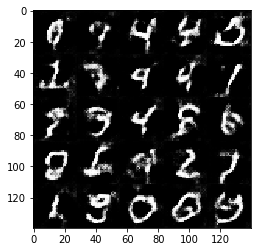

Epoch 1/2... Batch 410... Discriminator Loss: 1.1229... Generator Loss: 0.6196
Epoch 1/2... Batch 420... Discriminator Loss: 1.1279... Generator Loss: 0.6096
Epoch 1/2... Batch 430... Discriminator Loss: 1.0010... Generator Loss: 1.3124
Epoch 1/2... Batch 440... Discriminator Loss: 1.0676... Generator Loss: 1.5965
Epoch 1/2... Batch 450... Discriminator Loss: 1.0915... Generator Loss: 1.3002
Epoch 1/2... Batch 460... Discriminator Loss: 1.1763... Generator Loss: 0.8586
Epoch 1/2... Batch 470... Discriminator Loss: 1.0297... Generator Loss: 1.1173
Epoch 1/2... Batch 480... Discriminator Loss: 0.9871... Generator Loss: 1.3449
Epoch 1/2... Batch 490... Discriminator Loss: 1.4956... Generator Loss: 0.3539
Epoch 1/2... Batch 500... Discriminator Loss: 0.9461... Generator Loss: 1.2048


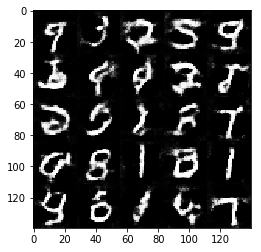

Epoch 1/2... Batch 510... Discriminator Loss: 1.1345... Generator Loss: 0.7095
Epoch 1/2... Batch 520... Discriminator Loss: 1.2635... Generator Loss: 1.3773
Epoch 1/2... Batch 530... Discriminator Loss: 1.2183... Generator Loss: 1.3122
Epoch 1/2... Batch 540... Discriminator Loss: 1.0556... Generator Loss: 1.1406
Epoch 1/2... Batch 550... Discriminator Loss: 1.0483... Generator Loss: 0.6165
Epoch 1/2... Batch 560... Discriminator Loss: 1.1490... Generator Loss: 1.1381
Epoch 1/2... Batch 570... Discriminator Loss: 1.2306... Generator Loss: 0.4878
Epoch 1/2... Batch 580... Discriminator Loss: 1.2321... Generator Loss: 0.4845
Epoch 1/2... Batch 590... Discriminator Loss: 1.1343... Generator Loss: 0.6949
Epoch 1/2... Batch 600... Discriminator Loss: 1.0067... Generator Loss: 0.8987


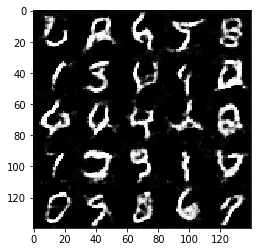

Epoch 1/2... Batch 610... Discriminator Loss: 1.2435... Generator Loss: 0.4861
Epoch 1/2... Batch 620... Discriminator Loss: 1.0302... Generator Loss: 0.7046
Epoch 1/2... Batch 630... Discriminator Loss: 1.2336... Generator Loss: 1.8266
Epoch 1/2... Batch 640... Discriminator Loss: 0.9680... Generator Loss: 1.0956
Epoch 1/2... Batch 650... Discriminator Loss: 0.9699... Generator Loss: 1.0738
Epoch 1/2... Batch 660... Discriminator Loss: 1.0218... Generator Loss: 1.0069
Epoch 1/2... Batch 670... Discriminator Loss: 1.1468... Generator Loss: 1.6140
Epoch 1/2... Batch 680... Discriminator Loss: 1.3359... Generator Loss: 0.4587
Epoch 1/2... Batch 690... Discriminator Loss: 0.9598... Generator Loss: 1.4148
Epoch 1/2... Batch 700... Discriminator Loss: 1.0321... Generator Loss: 0.7784


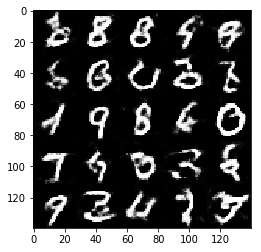

Epoch 1/2... Batch 710... Discriminator Loss: 1.0512... Generator Loss: 0.9070
Epoch 1/2... Batch 720... Discriminator Loss: 0.8715... Generator Loss: 1.0458
Epoch 1/2... Batch 730... Discriminator Loss: 0.8893... Generator Loss: 0.7869
Epoch 1/2... Batch 740... Discriminator Loss: 1.1432... Generator Loss: 0.5647
Epoch 1/2... Batch 750... Discriminator Loss: 1.0626... Generator Loss: 0.9440
Epoch 1/2... Batch 760... Discriminator Loss: 0.9736... Generator Loss: 0.8273
Epoch 1/2... Batch 770... Discriminator Loss: 1.1976... Generator Loss: 0.4775
Epoch 1/2... Batch 780... Discriminator Loss: 0.9813... Generator Loss: 0.8142
Epoch 1/2... Batch 790... Discriminator Loss: 1.4905... Generator Loss: 0.3413
Epoch 1/2... Batch 800... Discriminator Loss: 0.8711... Generator Loss: 0.7618


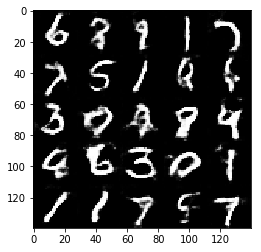

Epoch 1/2... Batch 810... Discriminator Loss: 1.0040... Generator Loss: 0.7392
Epoch 1/2... Batch 820... Discriminator Loss: 1.0803... Generator Loss: 0.5725
Epoch 1/2... Batch 830... Discriminator Loss: 1.2551... Generator Loss: 0.4650
Epoch 1/2... Batch 840... Discriminator Loss: 0.9331... Generator Loss: 0.9390
Epoch 1/2... Batch 850... Discriminator Loss: 0.8994... Generator Loss: 1.0148
Epoch 1/2... Batch 860... Discriminator Loss: 1.1699... Generator Loss: 0.5157
Epoch 1/2... Batch 870... Discriminator Loss: 1.0581... Generator Loss: 0.6540
Epoch 1/2... Batch 880... Discriminator Loss: 1.4400... Generator Loss: 0.3665
Epoch 1/2... Batch 890... Discriminator Loss: 0.9010... Generator Loss: 0.7514
Epoch 1/2... Batch 900... Discriminator Loss: 0.8071... Generator Loss: 1.3119


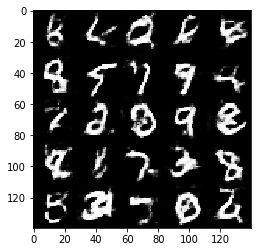

Epoch 1/2... Batch 910... Discriminator Loss: 0.8476... Generator Loss: 0.9025
Epoch 1/2... Batch 920... Discriminator Loss: 0.9583... Generator Loss: 0.6602
Epoch 1/2... Batch 930... Discriminator Loss: 0.8554... Generator Loss: 1.2433
Epoch 2/2... Batch 10... Discriminator Loss: 1.0928... Generator Loss: 0.6095
Epoch 2/2... Batch 20... Discriminator Loss: 1.0286... Generator Loss: 0.6381
Epoch 2/2... Batch 30... Discriminator Loss: 0.8876... Generator Loss: 0.7712
Epoch 2/2... Batch 40... Discriminator Loss: 0.8088... Generator Loss: 1.0229
Epoch 2/2... Batch 50... Discriminator Loss: 2.1784... Generator Loss: 0.1936
Epoch 2/2... Batch 60... Discriminator Loss: 1.0483... Generator Loss: 0.6819
Epoch 2/2... Batch 70... Discriminator Loss: 0.9761... Generator Loss: 0.6639
Epoch 2/2... Batch 80... Discriminator Loss: 0.8597... Generator Loss: 0.9472
Epoch 2/2... Batch 90... Discriminator Loss: 0.9047... Generator Loss: 1.0448
Epoch 2/2... Batch 100... Discriminator Loss: 1.9698... Gener

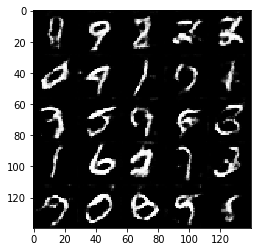

Epoch 2/2... Batch 110... Discriminator Loss: 0.8244... Generator Loss: 0.9771
Epoch 2/2... Batch 120... Discriminator Loss: 1.1349... Generator Loss: 0.6348
Epoch 2/2... Batch 130... Discriminator Loss: 0.8683... Generator Loss: 1.3834
Epoch 2/2... Batch 140... Discriminator Loss: 0.9024... Generator Loss: 0.7631
Epoch 2/2... Batch 150... Discriminator Loss: 1.3442... Generator Loss: 0.4200
Epoch 2/2... Batch 160... Discriminator Loss: 1.3279... Generator Loss: 0.3914
Epoch 2/2... Batch 170... Discriminator Loss: 1.6903... Generator Loss: 0.2613
Epoch 2/2... Batch 180... Discriminator Loss: 0.9719... Generator Loss: 0.7161
Epoch 2/2... Batch 190... Discriminator Loss: 1.1453... Generator Loss: 0.5774
Epoch 2/2... Batch 200... Discriminator Loss: 0.8422... Generator Loss: 1.0370


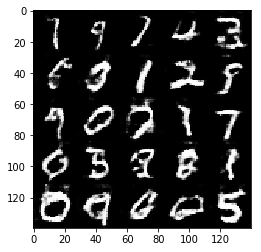

Epoch 2/2... Batch 210... Discriminator Loss: 1.1174... Generator Loss: 0.6078
Epoch 2/2... Batch 220... Discriminator Loss: 1.0682... Generator Loss: 0.6152
Epoch 2/2... Batch 230... Discriminator Loss: 1.3260... Generator Loss: 2.7174
Epoch 2/2... Batch 240... Discriminator Loss: 0.8093... Generator Loss: 0.9455
Epoch 2/2... Batch 250... Discriminator Loss: 1.0365... Generator Loss: 0.7324
Epoch 2/2... Batch 260... Discriminator Loss: 0.9146... Generator Loss: 0.8149
Epoch 2/2... Batch 270... Discriminator Loss: 1.2254... Generator Loss: 1.9320
Epoch 2/2... Batch 280... Discriminator Loss: 0.7643... Generator Loss: 1.0887
Epoch 2/2... Batch 290... Discriminator Loss: 0.9705... Generator Loss: 0.7054
Epoch 2/2... Batch 300... Discriminator Loss: 1.3240... Generator Loss: 0.4012


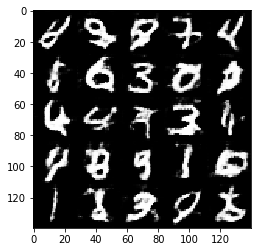

Epoch 2/2... Batch 310... Discriminator Loss: 1.1035... Generator Loss: 1.7691
Epoch 2/2... Batch 320... Discriminator Loss: 0.7072... Generator Loss: 1.1225
Epoch 2/2... Batch 330... Discriminator Loss: 0.8614... Generator Loss: 0.9515
Epoch 2/2... Batch 340... Discriminator Loss: 0.8309... Generator Loss: 0.9871
Epoch 2/2... Batch 350... Discriminator Loss: 0.8937... Generator Loss: 1.1975
Epoch 2/2... Batch 360... Discriminator Loss: 0.9923... Generator Loss: 1.0543
Epoch 2/2... Batch 370... Discriminator Loss: 1.1729... Generator Loss: 0.6245
Epoch 2/2... Batch 380... Discriminator Loss: 0.6329... Generator Loss: 1.4090
Epoch 2/2... Batch 390... Discriminator Loss: 0.9479... Generator Loss: 0.6560
Epoch 2/2... Batch 400... Discriminator Loss: 0.7732... Generator Loss: 1.3441


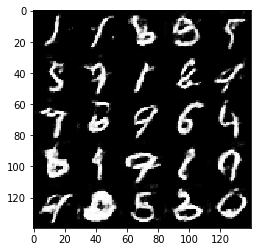

Epoch 2/2... Batch 410... Discriminator Loss: 0.8191... Generator Loss: 1.2172
Epoch 2/2... Batch 420... Discriminator Loss: 1.1740... Generator Loss: 2.0015
Epoch 2/2... Batch 430... Discriminator Loss: 0.8941... Generator Loss: 0.7854
Epoch 2/2... Batch 440... Discriminator Loss: 1.1677... Generator Loss: 1.7592
Epoch 2/2... Batch 450... Discriminator Loss: 1.4382... Generator Loss: 1.7523
Epoch 2/2... Batch 460... Discriminator Loss: 0.7772... Generator Loss: 1.1323
Epoch 2/2... Batch 470... Discriminator Loss: 0.8271... Generator Loss: 1.0039
Epoch 2/2... Batch 480... Discriminator Loss: 0.9272... Generator Loss: 0.7224
Epoch 2/2... Batch 490... Discriminator Loss: 1.1766... Generator Loss: 0.5232
Epoch 2/2... Batch 500... Discriminator Loss: 0.6437... Generator Loss: 1.1678


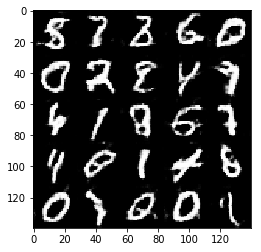

Epoch 2/2... Batch 510... Discriminator Loss: 1.2298... Generator Loss: 0.5450
Epoch 2/2... Batch 520... Discriminator Loss: 0.8656... Generator Loss: 1.1509
Epoch 2/2... Batch 530... Discriminator Loss: 1.0651... Generator Loss: 0.6544
Epoch 2/2... Batch 540... Discriminator Loss: 1.1944... Generator Loss: 0.5112
Epoch 2/2... Batch 550... Discriminator Loss: 0.7929... Generator Loss: 1.0757
Epoch 2/2... Batch 560... Discriminator Loss: 0.9164... Generator Loss: 1.1077
Epoch 2/2... Batch 570... Discriminator Loss: 1.5230... Generator Loss: 0.3228
Epoch 2/2... Batch 580... Discriminator Loss: 1.3140... Generator Loss: 0.4981
Epoch 2/2... Batch 590... Discriminator Loss: 1.2064... Generator Loss: 0.5249
Epoch 2/2... Batch 600... Discriminator Loss: 0.8466... Generator Loss: 0.7989


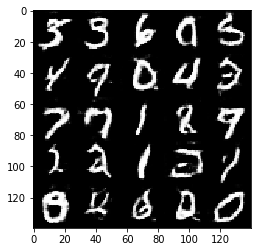

Epoch 2/2... Batch 610... Discriminator Loss: 0.7651... Generator Loss: 0.9651
Epoch 2/2... Batch 620... Discriminator Loss: 0.7347... Generator Loss: 1.0172
Epoch 2/2... Batch 630... Discriminator Loss: 1.2717... Generator Loss: 0.6692
Epoch 2/2... Batch 640... Discriminator Loss: 1.4288... Generator Loss: 0.4284
Epoch 2/2... Batch 650... Discriminator Loss: 0.6816... Generator Loss: 1.2840
Epoch 2/2... Batch 660... Discriminator Loss: 0.8247... Generator Loss: 1.0068
Epoch 2/2... Batch 670... Discriminator Loss: 0.8923... Generator Loss: 1.0299
Epoch 2/2... Batch 680... Discriminator Loss: 1.3373... Generator Loss: 0.5139
Epoch 2/2... Batch 690... Discriminator Loss: 0.8766... Generator Loss: 1.3807
Epoch 2/2... Batch 700... Discriminator Loss: 0.6473... Generator Loss: 1.2762


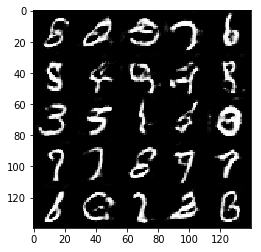

Epoch 2/2... Batch 710... Discriminator Loss: 0.9042... Generator Loss: 1.0889
Epoch 2/2... Batch 720... Discriminator Loss: 0.6203... Generator Loss: 1.3334
Epoch 2/2... Batch 730... Discriminator Loss: 0.9536... Generator Loss: 0.6427
Epoch 2/2... Batch 740... Discriminator Loss: 1.0599... Generator Loss: 0.6445
Epoch 2/2... Batch 750... Discriminator Loss: 1.2583... Generator Loss: 0.5967
Epoch 2/2... Batch 760... Discriminator Loss: 0.7205... Generator Loss: 1.0331
Epoch 2/2... Batch 770... Discriminator Loss: 0.8464... Generator Loss: 0.8557
Epoch 2/2... Batch 780... Discriminator Loss: 1.0932... Generator Loss: 0.5913
Epoch 2/2... Batch 790... Discriminator Loss: 0.8486... Generator Loss: 0.9175
Epoch 2/2... Batch 800... Discriminator Loss: 0.7578... Generator Loss: 1.1957


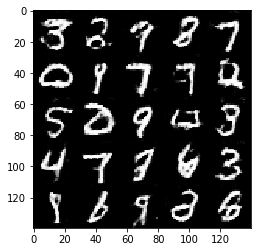

Epoch 2/2... Batch 810... Discriminator Loss: 1.0999... Generator Loss: 0.5980
Epoch 2/2... Batch 820... Discriminator Loss: 1.0417... Generator Loss: 0.6878
Epoch 2/2... Batch 830... Discriminator Loss: 0.6684... Generator Loss: 1.6428
Epoch 2/2... Batch 840... Discriminator Loss: 0.4926... Generator Loss: 1.9071
Epoch 2/2... Batch 850... Discriminator Loss: 0.7908... Generator Loss: 1.2760
Epoch 2/2... Batch 860... Discriminator Loss: 0.6243... Generator Loss: 1.1835
Epoch 2/2... Batch 870... Discriminator Loss: 1.1837... Generator Loss: 0.4890
Epoch 2/2... Batch 880... Discriminator Loss: 0.8226... Generator Loss: 0.8882
Epoch 2/2... Batch 890... Discriminator Loss: 0.6233... Generator Loss: 1.0980
Epoch 2/2... Batch 900... Discriminator Loss: 0.7901... Generator Loss: 0.8769


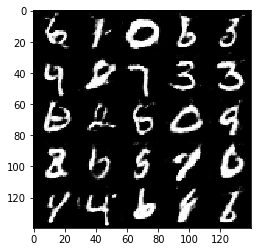

Epoch 2/2... Batch 910... Discriminator Loss: 1.9424... Generator Loss: 0.2365
Epoch 2/2... Batch 920... Discriminator Loss: 0.9928... Generator Loss: 0.8565
Epoch 2/2... Batch 930... Discriminator Loss: 0.7165... Generator Loss: 1.5914


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.8395... Generator Loss: 0.9065
Epoch 1/1... Batch 20... Discriminator Loss: 0.5652... Generator Loss: 1.5350
Epoch 1/1... Batch 30... Discriminator Loss: 0.3729... Generator Loss: 2.5508
Epoch 1/1... Batch 40... Discriminator Loss: 1.3749... Generator Loss: 0.4433
Epoch 1/1... Batch 50... Discriminator Loss: 1.4151... Generator Loss: 0.4898
Epoch 1/1... Batch 60... Discriminator Loss: 0.7311... Generator Loss: 1.2949
Epoch 1/1... Batch 70... Discriminator Loss: 0.8421... Generator Loss: 0.9555
Epoch 1/1... Batch 80... Discriminator Loss: 0.4564... Generator Loss: 2.0958
Epoch 1/1... Batch 90... Discriminator Loss: 1.8253... Generator Loss: 5.4969
Epoch 1/1... Batch 100... Discriminator Loss: 1.1960... Generator Loss: 0.5294


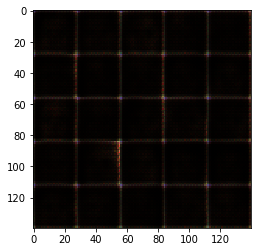

Epoch 1/1... Batch 110... Discriminator Loss: 0.4912... Generator Loss: 1.6429
Epoch 1/1... Batch 120... Discriminator Loss: 0.3443... Generator Loss: 2.2790
Epoch 1/1... Batch 130... Discriminator Loss: 0.1803... Generator Loss: 3.3628
Epoch 1/1... Batch 140... Discriminator Loss: 0.7221... Generator Loss: 0.8409
Epoch 1/1... Batch 150... Discriminator Loss: 1.6284... Generator Loss: 0.3053
Epoch 1/1... Batch 160... Discriminator Loss: 1.5496... Generator Loss: 0.3349
Epoch 1/1... Batch 170... Discriminator Loss: 0.4577... Generator Loss: 1.6489
Epoch 1/1... Batch 180... Discriminator Loss: 0.5695... Generator Loss: 1.1948
Epoch 1/1... Batch 190... Discriminator Loss: 0.3147... Generator Loss: 2.0258
Epoch 1/1... Batch 200... Discriminator Loss: 0.4752... Generator Loss: 3.3617


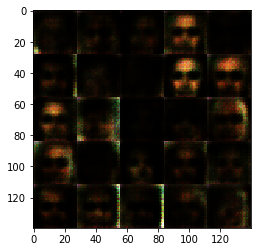

Epoch 1/1... Batch 210... Discriminator Loss: 0.5757... Generator Loss: 1.3002
Epoch 1/1... Batch 220... Discriminator Loss: 1.9014... Generator Loss: 3.7075
Epoch 1/1... Batch 230... Discriminator Loss: 2.2486... Generator Loss: 0.1545
Epoch 1/1... Batch 240... Discriminator Loss: 1.3751... Generator Loss: 0.4469
Epoch 1/1... Batch 250... Discriminator Loss: 0.5446... Generator Loss: 5.7204
Epoch 1/1... Batch 260... Discriminator Loss: 0.5821... Generator Loss: 1.4876
Epoch 1/1... Batch 270... Discriminator Loss: 0.6103... Generator Loss: 1.2376
Epoch 1/1... Batch 280... Discriminator Loss: 0.4030... Generator Loss: 1.8926
Epoch 1/1... Batch 290... Discriminator Loss: 1.7931... Generator Loss: 0.2629
Epoch 1/1... Batch 300... Discriminator Loss: 0.8167... Generator Loss: 3.3872


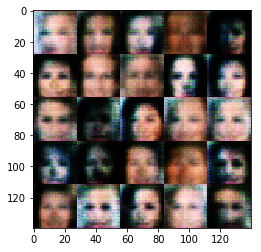

Epoch 1/1... Batch 310... Discriminator Loss: 2.7701... Generator Loss: 0.0955
Epoch 1/1... Batch 320... Discriminator Loss: 1.2033... Generator Loss: 0.5177
Epoch 1/1... Batch 330... Discriminator Loss: 0.7936... Generator Loss: 4.2282
Epoch 1/1... Batch 340... Discriminator Loss: 0.2981... Generator Loss: 2.1452
Epoch 1/1... Batch 350... Discriminator Loss: 0.4693... Generator Loss: 3.3639
Epoch 1/1... Batch 360... Discriminator Loss: 0.5208... Generator Loss: 2.1968
Epoch 1/1... Batch 370... Discriminator Loss: 1.4038... Generator Loss: 0.3950
Epoch 1/1... Batch 380... Discriminator Loss: 0.1544... Generator Loss: 3.5168
Epoch 1/1... Batch 390... Discriminator Loss: 1.3266... Generator Loss: 0.4491
Epoch 1/1... Batch 400... Discriminator Loss: 0.4390... Generator Loss: 1.3266


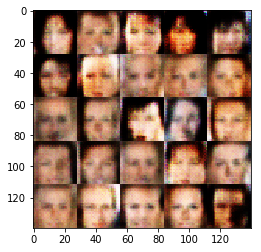

Epoch 1/1... Batch 410... Discriminator Loss: 0.8872... Generator Loss: 0.8967
Epoch 1/1... Batch 420... Discriminator Loss: 1.0446... Generator Loss: 6.8417
Epoch 1/1... Batch 430... Discriminator Loss: 0.5848... Generator Loss: 3.1590
Epoch 1/1... Batch 440... Discriminator Loss: 0.2119... Generator Loss: 2.4285
Epoch 1/1... Batch 450... Discriminator Loss: 0.6177... Generator Loss: 2.4933
Epoch 1/1... Batch 460... Discriminator Loss: 0.3731... Generator Loss: 3.2040
Epoch 1/1... Batch 470... Discriminator Loss: 1.9494... Generator Loss: 2.4061
Epoch 1/1... Batch 480... Discriminator Loss: 1.1067... Generator Loss: 1.0730
Epoch 1/1... Batch 490... Discriminator Loss: 2.9665... Generator Loss: 3.0455
Epoch 1/1... Batch 500... Discriminator Loss: 0.7086... Generator Loss: 0.8789


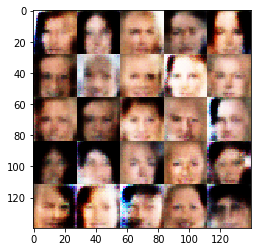

Epoch 1/1... Batch 510... Discriminator Loss: 2.3480... Generator Loss: 0.1320
Epoch 1/1... Batch 520... Discriminator Loss: 0.3541... Generator Loss: 4.1662
Epoch 1/1... Batch 530... Discriminator Loss: 0.2393... Generator Loss: 2.6757
Epoch 1/1... Batch 540... Discriminator Loss: 0.7266... Generator Loss: 1.3826
Epoch 1/1... Batch 550... Discriminator Loss: 0.3115... Generator Loss: 3.0094
Epoch 1/1... Batch 560... Discriminator Loss: 0.4247... Generator Loss: 2.3625
Epoch 1/1... Batch 570... Discriminator Loss: 0.3939... Generator Loss: 1.4846
Epoch 1/1... Batch 580... Discriminator Loss: 0.3352... Generator Loss: 1.6955
Epoch 1/1... Batch 590... Discriminator Loss: 0.5543... Generator Loss: 1.0797
Epoch 1/1... Batch 600... Discriminator Loss: 0.8796... Generator Loss: 1.1696


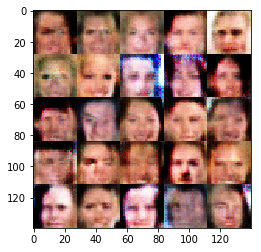

Epoch 1/1... Batch 610... Discriminator Loss: 1.3043... Generator Loss: 0.4279
Epoch 1/1... Batch 620... Discriminator Loss: 0.4026... Generator Loss: 1.8245
Epoch 1/1... Batch 630... Discriminator Loss: 1.2397... Generator Loss: 2.0770
Epoch 1/1... Batch 640... Discriminator Loss: 1.6892... Generator Loss: 0.9408
Epoch 1/1... Batch 650... Discriminator Loss: 1.2336... Generator Loss: 0.7485
Epoch 1/1... Batch 660... Discriminator Loss: 1.3560... Generator Loss: 0.6641
Epoch 1/1... Batch 670... Discriminator Loss: 1.1158... Generator Loss: 0.8642
Epoch 1/1... Batch 680... Discriminator Loss: 1.0071... Generator Loss: 2.2349
Epoch 1/1... Batch 690... Discriminator Loss: 0.5345... Generator Loss: 2.4278
Epoch 1/1... Batch 700... Discriminator Loss: 0.9842... Generator Loss: 0.6501


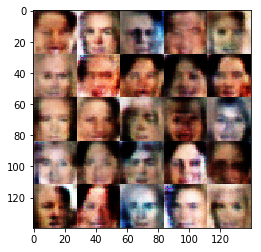

Epoch 1/1... Batch 710... Discriminator Loss: 1.9368... Generator Loss: 0.2110
Epoch 1/1... Batch 720... Discriminator Loss: 0.4342... Generator Loss: 1.8454
Epoch 1/1... Batch 730... Discriminator Loss: 0.9884... Generator Loss: 1.1850
Epoch 1/1... Batch 740... Discriminator Loss: 0.3558... Generator Loss: 1.7202
Epoch 1/1... Batch 750... Discriminator Loss: 1.4485... Generator Loss: 0.3351
Epoch 1/1... Batch 760... Discriminator Loss: 1.1101... Generator Loss: 0.5021
Epoch 1/1... Batch 770... Discriminator Loss: 0.6727... Generator Loss: 1.0106
Epoch 1/1... Batch 780... Discriminator Loss: 1.1469... Generator Loss: 0.5353
Epoch 1/1... Batch 790... Discriminator Loss: 0.4550... Generator Loss: 1.3182
Epoch 1/1... Batch 800... Discriminator Loss: 0.5541... Generator Loss: 2.6947


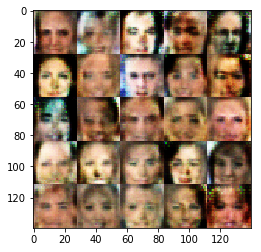

Epoch 1/1... Batch 810... Discriminator Loss: 0.3341... Generator Loss: 2.9521
Epoch 1/1... Batch 820... Discriminator Loss: 0.3630... Generator Loss: 1.9650
Epoch 1/1... Batch 830... Discriminator Loss: 0.5713... Generator Loss: 1.0555
Epoch 1/1... Batch 840... Discriminator Loss: 0.7368... Generator Loss: 3.5677
Epoch 1/1... Batch 850... Discriminator Loss: 0.2917... Generator Loss: 2.1243
Epoch 1/1... Batch 860... Discriminator Loss: 0.4284... Generator Loss: 2.9575
Epoch 1/1... Batch 870... Discriminator Loss: 0.3283... Generator Loss: 2.8120
Epoch 1/1... Batch 880... Discriminator Loss: 0.1342... Generator Loss: 3.2973
Epoch 1/1... Batch 890... Discriminator Loss: 1.9685... Generator Loss: 0.2070
Epoch 1/1... Batch 900... Discriminator Loss: 0.3916... Generator Loss: 1.8593


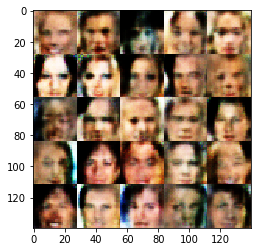

Epoch 1/1... Batch 910... Discriminator Loss: 1.0560... Generator Loss: 0.5162
Epoch 1/1... Batch 920... Discriminator Loss: 0.2378... Generator Loss: 2.0225
Epoch 1/1... Batch 930... Discriminator Loss: 0.2069... Generator Loss: 3.1657
Epoch 1/1... Batch 940... Discriminator Loss: 0.6718... Generator Loss: 1.1821
Epoch 1/1... Batch 950... Discriminator Loss: 0.7139... Generator Loss: 2.1483
Epoch 1/1... Batch 960... Discriminator Loss: 0.2894... Generator Loss: 3.2058
Epoch 1/1... Batch 970... Discriminator Loss: 0.8634... Generator Loss: 1.1511
Epoch 1/1... Batch 980... Discriminator Loss: 0.7831... Generator Loss: 0.8360
Epoch 1/1... Batch 990... Discriminator Loss: 0.2529... Generator Loss: 2.0371
Epoch 1/1... Batch 1000... Discriminator Loss: 0.8356... Generator Loss: 0.7800


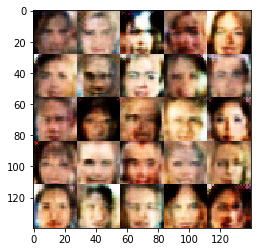

Epoch 1/1... Batch 1010... Discriminator Loss: 0.6897... Generator Loss: 2.3254
Epoch 1/1... Batch 1020... Discriminator Loss: 1.5327... Generator Loss: 2.1048
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2630... Generator Loss: 0.8036
Epoch 1/1... Batch 1040... Discriminator Loss: 0.9400... Generator Loss: 0.9664
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2416... Generator Loss: 3.7568
Epoch 1/1... Batch 1060... Discriminator Loss: 0.6440... Generator Loss: 2.5017
Epoch 1/1... Batch 1070... Discriminator Loss: 0.8325... Generator Loss: 1.5132
Epoch 1/1... Batch 1080... Discriminator Loss: 1.8807... Generator Loss: 1.8358
Epoch 1/1... Batch 1090... Discriminator Loss: 0.3153... Generator Loss: 3.4406
Epoch 1/1... Batch 1100... Discriminator Loss: 0.3761... Generator Loss: 1.4497


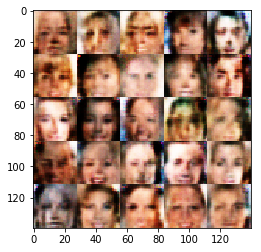

Epoch 1/1... Batch 1110... Discriminator Loss: 0.3185... Generator Loss: 2.6308
Epoch 1/1... Batch 1120... Discriminator Loss: 2.1847... Generator Loss: 1.1204
Epoch 1/1... Batch 1130... Discriminator Loss: 0.4718... Generator Loss: 1.6299
Epoch 1/1... Batch 1140... Discriminator Loss: 0.4237... Generator Loss: 2.3659
Epoch 1/1... Batch 1150... Discriminator Loss: 0.3714... Generator Loss: 1.8701
Epoch 1/1... Batch 1160... Discriminator Loss: 0.4540... Generator Loss: 2.6432
Epoch 1/1... Batch 1170... Discriminator Loss: 0.6277... Generator Loss: 1.8823
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4493... Generator Loss: 0.4361
Epoch 1/1... Batch 1190... Discriminator Loss: 1.0435... Generator Loss: 0.8962
Epoch 1/1... Batch 1200... Discriminator Loss: 0.5674... Generator Loss: 1.3910


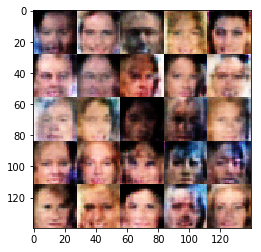

Epoch 1/1... Batch 1210... Discriminator Loss: 0.1726... Generator Loss: 3.0713
Epoch 1/1... Batch 1220... Discriminator Loss: 1.0180... Generator Loss: 1.2335
Epoch 1/1... Batch 1230... Discriminator Loss: 0.8277... Generator Loss: 1.1515
Epoch 1/1... Batch 1240... Discriminator Loss: 0.6532... Generator Loss: 0.8853
Epoch 1/1... Batch 1250... Discriminator Loss: 1.1182... Generator Loss: 1.0235
Epoch 1/1... Batch 1260... Discriminator Loss: 1.1044... Generator Loss: 0.8120
Epoch 1/1... Batch 1270... Discriminator Loss: 0.8858... Generator Loss: 0.8669
Epoch 1/1... Batch 1280... Discriminator Loss: 1.1422... Generator Loss: 2.5053
Epoch 1/1... Batch 1290... Discriminator Loss: 1.4960... Generator Loss: 2.7345
Epoch 1/1... Batch 1300... Discriminator Loss: 1.1303... Generator Loss: 0.8124


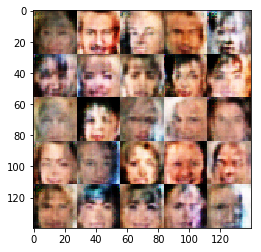

Epoch 1/1... Batch 1310... Discriminator Loss: 0.8934... Generator Loss: 1.3132
Epoch 1/1... Batch 1320... Discriminator Loss: 0.4195... Generator Loss: 1.9144
Epoch 1/1... Batch 1330... Discriminator Loss: 2.1026... Generator Loss: 0.1830
Epoch 1/1... Batch 1340... Discriminator Loss: 0.8498... Generator Loss: 1.4363
Epoch 1/1... Batch 1350... Discriminator Loss: 1.0089... Generator Loss: 0.7369
Epoch 1/1... Batch 1360... Discriminator Loss: 0.7182... Generator Loss: 1.1784
Epoch 1/1... Batch 1370... Discriminator Loss: 0.9449... Generator Loss: 0.6534
Epoch 1/1... Batch 1380... Discriminator Loss: 0.3626... Generator Loss: 1.7037
Epoch 1/1... Batch 1390... Discriminator Loss: 0.4498... Generator Loss: 1.8604
Epoch 1/1... Batch 1400... Discriminator Loss: 0.2869... Generator Loss: 3.0903


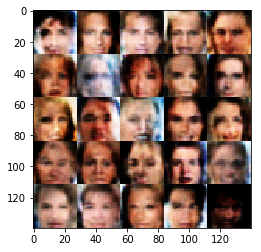

Epoch 1/1... Batch 1410... Discriminator Loss: 0.2807... Generator Loss: 2.3260
Epoch 1/1... Batch 1420... Discriminator Loss: 0.1578... Generator Loss: 3.0161
Epoch 1/1... Batch 1430... Discriminator Loss: 0.1512... Generator Loss: 2.5751
Epoch 1/1... Batch 1440... Discriminator Loss: 2.2253... Generator Loss: 3.3132
Epoch 1/1... Batch 1450... Discriminator Loss: 1.4614... Generator Loss: 0.4615
Epoch 1/1... Batch 1460... Discriminator Loss: 1.2063... Generator Loss: 1.5002
Epoch 1/1... Batch 1470... Discriminator Loss: 1.2965... Generator Loss: 1.0253
Epoch 1/1... Batch 1480... Discriminator Loss: 1.5205... Generator Loss: 0.5079
Epoch 1/1... Batch 1490... Discriminator Loss: 1.3838... Generator Loss: 0.6524
Epoch 1/1... Batch 1500... Discriminator Loss: 0.9549... Generator Loss: 1.0246


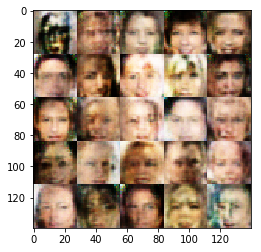

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2479... Generator Loss: 0.7339
Epoch 1/1... Batch 1520... Discriminator Loss: 1.2782... Generator Loss: 0.8483
Epoch 1/1... Batch 1530... Discriminator Loss: 1.0688... Generator Loss: 1.0442
Epoch 1/1... Batch 1540... Discriminator Loss: 1.1944... Generator Loss: 0.7817
Epoch 1/1... Batch 1550... Discriminator Loss: 0.9854... Generator Loss: 1.0169
Epoch 1/1... Batch 1560... Discriminator Loss: 1.1163... Generator Loss: 0.8106
Epoch 1/1... Batch 1570... Discriminator Loss: 1.0475... Generator Loss: 0.8184
Epoch 1/1... Batch 1580... Discriminator Loss: 1.1493... Generator Loss: 0.9252
Epoch 1/1... Batch 1590... Discriminator Loss: 1.0074... Generator Loss: 0.8950
Epoch 1/1... Batch 1600... Discriminator Loss: 1.1065... Generator Loss: 1.0636


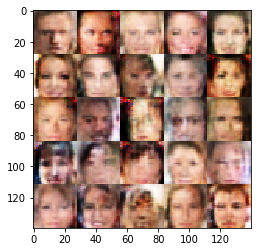

Epoch 1/1... Batch 1610... Discriminator Loss: 0.8422... Generator Loss: 1.0485
Epoch 1/1... Batch 1620... Discriminator Loss: 1.0963... Generator Loss: 0.8273
Epoch 1/1... Batch 1630... Discriminator Loss: 1.0194... Generator Loss: 0.8172
Epoch 1/1... Batch 1640... Discriminator Loss: 1.1707... Generator Loss: 0.9675
Epoch 1/1... Batch 1650... Discriminator Loss: 1.4020... Generator Loss: 0.5999
Epoch 1/1... Batch 1660... Discriminator Loss: 1.2254... Generator Loss: 0.6704
Epoch 1/1... Batch 1670... Discriminator Loss: 1.0784... Generator Loss: 0.7664
Epoch 1/1... Batch 1680... Discriminator Loss: 0.8822... Generator Loss: 0.9458
Epoch 1/1... Batch 1690... Discriminator Loss: 1.0840... Generator Loss: 1.0705
Epoch 1/1... Batch 1700... Discriminator Loss: 1.5230... Generator Loss: 0.4674


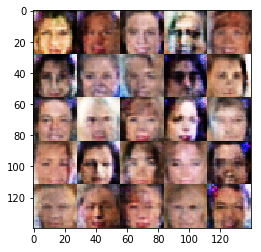

Epoch 1/1... Batch 1710... Discriminator Loss: 1.3413... Generator Loss: 1.0609
Epoch 1/1... Batch 1720... Discriminator Loss: 1.1450... Generator Loss: 0.5933
Epoch 1/1... Batch 1730... Discriminator Loss: 1.2200... Generator Loss: 0.6681
Epoch 1/1... Batch 1740... Discriminator Loss: 1.1604... Generator Loss: 0.7048
Epoch 1/1... Batch 1750... Discriminator Loss: 1.0281... Generator Loss: 1.0224
Epoch 1/1... Batch 1760... Discriminator Loss: 1.5757... Generator Loss: 0.3466
Epoch 1/1... Batch 1770... Discriminator Loss: 0.9605... Generator Loss: 0.8944
Epoch 1/1... Batch 1780... Discriminator Loss: 0.9375... Generator Loss: 1.6782
Epoch 1/1... Batch 1790... Discriminator Loss: 0.2518... Generator Loss: 2.2859
Epoch 1/1... Batch 1800... Discriminator Loss: 0.2863... Generator Loss: 2.3129


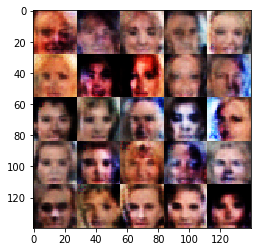

Epoch 1/1... Batch 1810... Discriminator Loss: 0.4379... Generator Loss: 1.8349
Epoch 1/1... Batch 1820... Discriminator Loss: 0.5679... Generator Loss: 1.1387
Epoch 1/1... Batch 1830... Discriminator Loss: 1.0975... Generator Loss: 2.0798
Epoch 1/1... Batch 1840... Discriminator Loss: 0.8255... Generator Loss: 1.0622
Epoch 1/1... Batch 1850... Discriminator Loss: 0.9605... Generator Loss: 1.1102
Epoch 1/1... Batch 1860... Discriminator Loss: 0.3050... Generator Loss: 2.2360
Epoch 1/1... Batch 1870... Discriminator Loss: 0.2445... Generator Loss: 2.6387
Epoch 1/1... Batch 1880... Discriminator Loss: 1.3394... Generator Loss: 3.2895
Epoch 1/1... Batch 1890... Discriminator Loss: 0.4360... Generator Loss: 1.4496
Epoch 1/1... Batch 1900... Discriminator Loss: 0.9547... Generator Loss: 0.8166


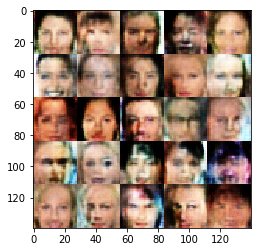

Epoch 1/1... Batch 1910... Discriminator Loss: 1.0920... Generator Loss: 1.9112
Epoch 1/1... Batch 1920... Discriminator Loss: 0.8029... Generator Loss: 1.5404
Epoch 1/1... Batch 1930... Discriminator Loss: 0.3447... Generator Loss: 2.5964
Epoch 1/1... Batch 1940... Discriminator Loss: 0.6789... Generator Loss: 1.6444
Epoch 1/1... Batch 1950... Discriminator Loss: 0.1310... Generator Loss: 2.7943
Epoch 1/1... Batch 1960... Discriminator Loss: 0.0751... Generator Loss: 4.3097
Epoch 1/1... Batch 1970... Discriminator Loss: 1.3142... Generator Loss: 2.2736
Epoch 1/1... Batch 1980... Discriminator Loss: 0.7291... Generator Loss: 1.9252
Epoch 1/1... Batch 1990... Discriminator Loss: 0.8278... Generator Loss: 2.0887
Epoch 1/1... Batch 2000... Discriminator Loss: 0.9833... Generator Loss: 0.7593


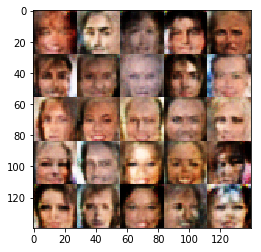

Epoch 1/1... Batch 2010... Discriminator Loss: 1.4652... Generator Loss: 0.3259
Epoch 1/1... Batch 2020... Discriminator Loss: 0.3495... Generator Loss: 1.5866
Epoch 1/1... Batch 2030... Discriminator Loss: 1.1127... Generator Loss: 0.9763
Epoch 1/1... Batch 2040... Discriminator Loss: 1.0301... Generator Loss: 0.9229
Epoch 1/1... Batch 2050... Discriminator Loss: 0.9828... Generator Loss: 0.8707
Epoch 1/1... Batch 2060... Discriminator Loss: 0.9863... Generator Loss: 0.8700
Epoch 1/1... Batch 2070... Discriminator Loss: 0.9464... Generator Loss: 1.1726
Epoch 1/1... Batch 2080... Discriminator Loss: 1.4325... Generator Loss: 0.4790
Epoch 1/1... Batch 2090... Discriminator Loss: 0.1099... Generator Loss: 4.0310
Epoch 1/1... Batch 2100... Discriminator Loss: 0.5953... Generator Loss: 1.0147


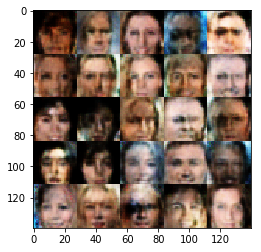

Epoch 1/1... Batch 2110... Discriminator Loss: 1.3837... Generator Loss: 0.9238
Epoch 1/1... Batch 2120... Discriminator Loss: 0.9546... Generator Loss: 0.6872
Epoch 1/1... Batch 2130... Discriminator Loss: 0.8001... Generator Loss: 1.0442
Epoch 1/1... Batch 2140... Discriminator Loss: 0.3772... Generator Loss: 2.7790
Epoch 1/1... Batch 2150... Discriminator Loss: 0.3431... Generator Loss: 4.2025
Epoch 1/1... Batch 2160... Discriminator Loss: 0.4702... Generator Loss: 1.2803
Epoch 1/1... Batch 2170... Discriminator Loss: 0.1746... Generator Loss: 2.8550
Epoch 1/1... Batch 2180... Discriminator Loss: 0.6345... Generator Loss: 1.6681
Epoch 1/1... Batch 2190... Discriminator Loss: 0.3004... Generator Loss: 2.2561
Epoch 1/1... Batch 2200... Discriminator Loss: 0.4310... Generator Loss: 4.7684


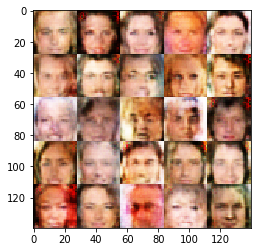

Epoch 1/1... Batch 2210... Discriminator Loss: 0.7677... Generator Loss: 0.9339
Epoch 1/1... Batch 2220... Discriminator Loss: 0.5845... Generator Loss: 3.0580
Epoch 1/1... Batch 2230... Discriminator Loss: 0.5752... Generator Loss: 1.3105
Epoch 1/1... Batch 2240... Discriminator Loss: 1.1171... Generator Loss: 0.6352
Epoch 1/1... Batch 2250... Discriminator Loss: 0.1250... Generator Loss: 3.3309
Epoch 1/1... Batch 2260... Discriminator Loss: 0.1588... Generator Loss: 2.7200
Epoch 1/1... Batch 2270... Discriminator Loss: 0.6661... Generator Loss: 0.9608
Epoch 1/1... Batch 2280... Discriminator Loss: 1.0282... Generator Loss: 1.4473
Epoch 1/1... Batch 2290... Discriminator Loss: 0.3227... Generator Loss: 1.7093
Epoch 1/1... Batch 2300... Discriminator Loss: 1.2225... Generator Loss: 0.6617


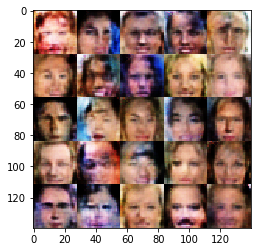

Epoch 1/1... Batch 2310... Discriminator Loss: 1.1504... Generator Loss: 0.8811
Epoch 1/1... Batch 2320... Discriminator Loss: 0.5244... Generator Loss: 1.3878
Epoch 1/1... Batch 2330... Discriminator Loss: 1.2671... Generator Loss: 0.4544
Epoch 1/1... Batch 2340... Discriminator Loss: 0.8680... Generator Loss: 1.1631
Epoch 1/1... Batch 2350... Discriminator Loss: 1.0330... Generator Loss: 0.7728
Epoch 1/1... Batch 2360... Discriminator Loss: 0.8212... Generator Loss: 1.7824
Epoch 1/1... Batch 2370... Discriminator Loss: 0.9149... Generator Loss: 0.9160
Epoch 1/1... Batch 2380... Discriminator Loss: 0.6619... Generator Loss: 0.9293
Epoch 1/1... Batch 2390... Discriminator Loss: 0.2560... Generator Loss: 2.8099
Epoch 1/1... Batch 2400... Discriminator Loss: 0.3680... Generator Loss: 1.5470


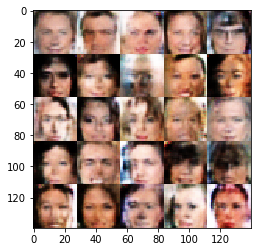

Epoch 1/1... Batch 2410... Discriminator Loss: 0.9858... Generator Loss: 0.6907
Epoch 1/1... Batch 2420... Discriminator Loss: 0.6411... Generator Loss: 2.0845
Epoch 1/1... Batch 2430... Discriminator Loss: 0.3738... Generator Loss: 3.9393
Epoch 1/1... Batch 2440... Discriminator Loss: 0.6418... Generator Loss: 1.3240
Epoch 1/1... Batch 2450... Discriminator Loss: 0.2665... Generator Loss: 3.4454
Epoch 1/1... Batch 2460... Discriminator Loss: 0.6592... Generator Loss: 3.5491
Epoch 1/1... Batch 2470... Discriminator Loss: 0.4169... Generator Loss: 1.6753
Epoch 1/1... Batch 2480... Discriminator Loss: 0.2627... Generator Loss: 3.0782
Epoch 1/1... Batch 2490... Discriminator Loss: 0.8994... Generator Loss: 0.8196
Epoch 1/1... Batch 2500... Discriminator Loss: 0.1544... Generator Loss: 4.3260


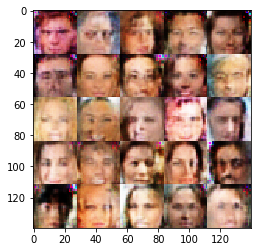

Epoch 1/1... Batch 2510... Discriminator Loss: 0.7139... Generator Loss: 2.1547
Epoch 1/1... Batch 2520... Discriminator Loss: 0.2186... Generator Loss: 4.0024
Epoch 1/1... Batch 2530... Discriminator Loss: 0.3278... Generator Loss: 2.5461
Epoch 1/1... Batch 2540... Discriminator Loss: 1.0974... Generator Loss: 0.5265
Epoch 1/1... Batch 2550... Discriminator Loss: 0.2378... Generator Loss: 2.2491
Epoch 1/1... Batch 2560... Discriminator Loss: 1.3831... Generator Loss: 0.4565
Epoch 1/1... Batch 2570... Discriminator Loss: 1.3634... Generator Loss: 0.3922
Epoch 1/1... Batch 2580... Discriminator Loss: 0.7713... Generator Loss: 1.1964
Epoch 1/1... Batch 2590... Discriminator Loss: 0.6280... Generator Loss: 4.0717
Epoch 1/1... Batch 2600... Discriminator Loss: 0.3838... Generator Loss: 1.8245


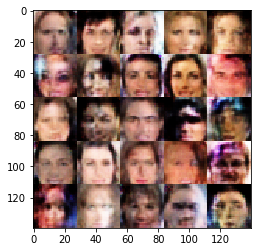

Epoch 1/1... Batch 2610... Discriminator Loss: 0.6276... Generator Loss: 1.4892
Epoch 1/1... Batch 2620... Discriminator Loss: 0.8280... Generator Loss: 1.1655
Epoch 1/1... Batch 2630... Discriminator Loss: 1.1570... Generator Loss: 1.1759
Epoch 1/1... Batch 2640... Discriminator Loss: 0.6179... Generator Loss: 1.3894
Epoch 1/1... Batch 2650... Discriminator Loss: 1.0716... Generator Loss: 0.7997
Epoch 1/1... Batch 2660... Discriminator Loss: 0.1033... Generator Loss: 5.5727
Epoch 1/1... Batch 2670... Discriminator Loss: 0.2159... Generator Loss: 3.3013
Epoch 1/1... Batch 2680... Discriminator Loss: 0.1096... Generator Loss: 3.9931
Epoch 1/1... Batch 2690... Discriminator Loss: 0.1196... Generator Loss: 7.6421
Epoch 1/1... Batch 2700... Discriminator Loss: 0.6431... Generator Loss: 1.3000


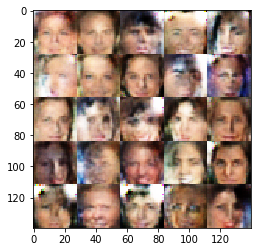

Epoch 1/1... Batch 2710... Discriminator Loss: 0.2263... Generator Loss: 2.5154
Epoch 1/1... Batch 2720... Discriminator Loss: 0.3238... Generator Loss: 2.0105
Epoch 1/1... Batch 2730... Discriminator Loss: 0.3986... Generator Loss: 1.6794
Epoch 1/1... Batch 2740... Discriminator Loss: 0.2676... Generator Loss: 2.5446
Epoch 1/1... Batch 2750... Discriminator Loss: 0.0413... Generator Loss: 4.8871
Epoch 1/1... Batch 2760... Discriminator Loss: 0.1819... Generator Loss: 2.6913
Epoch 1/1... Batch 2770... Discriminator Loss: 0.0085... Generator Loss: 11.6052
Epoch 1/1... Batch 2780... Discriminator Loss: 0.2978... Generator Loss: 1.7344
Epoch 1/1... Batch 2790... Discriminator Loss: 0.0501... Generator Loss: 5.0316
Epoch 1/1... Batch 2800... Discriminator Loss: 0.0394... Generator Loss: 5.7530


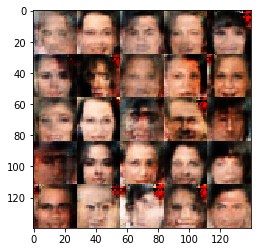

Epoch 1/1... Batch 2810... Discriminator Loss: 0.0380... Generator Loss: 6.2595
Epoch 1/1... Batch 2820... Discriminator Loss: 0.1012... Generator Loss: 3.2311
Epoch 1/1... Batch 2830... Discriminator Loss: 0.0371... Generator Loss: 4.9600
Epoch 1/1... Batch 2840... Discriminator Loss: 0.4879... Generator Loss: 5.5955
Epoch 1/1... Batch 2850... Discriminator Loss: 1.0353... Generator Loss: 4.5251
Epoch 1/1... Batch 2860... Discriminator Loss: 0.3134... Generator Loss: 2.3596
Epoch 1/1... Batch 2870... Discriminator Loss: 0.5247... Generator Loss: 3.0831
Epoch 1/1... Batch 2880... Discriminator Loss: 0.4641... Generator Loss: 1.9354
Epoch 1/1... Batch 2890... Discriminator Loss: 0.5358... Generator Loss: 2.1216
Epoch 1/1... Batch 2900... Discriminator Loss: 0.6084... Generator Loss: 2.2661


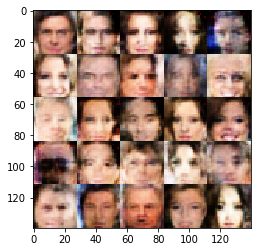

Epoch 1/1... Batch 2910... Discriminator Loss: 0.5216... Generator Loss: 2.7690
Epoch 1/1... Batch 2920... Discriminator Loss: 0.5494... Generator Loss: 1.7691
Epoch 1/1... Batch 2930... Discriminator Loss: 0.6207... Generator Loss: 1.8034
Epoch 1/1... Batch 2940... Discriminator Loss: 0.3976... Generator Loss: 2.0966
Epoch 1/1... Batch 2950... Discriminator Loss: 0.4244... Generator Loss: 4.7850
Epoch 1/1... Batch 2960... Discriminator Loss: 0.4634... Generator Loss: 1.5565
Epoch 1/1... Batch 2970... Discriminator Loss: 0.3311... Generator Loss: 1.9136
Epoch 1/1... Batch 2980... Discriminator Loss: 1.3165... Generator Loss: 1.1918
Epoch 1/1... Batch 2990... Discriminator Loss: 0.9925... Generator Loss: 1.2098
Epoch 1/1... Batch 3000... Discriminator Loss: 1.0169... Generator Loss: 0.9578


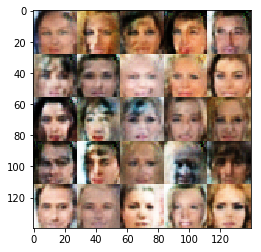

Epoch 1/1... Batch 3010... Discriminator Loss: 1.2429... Generator Loss: 0.8451
Epoch 1/1... Batch 3020... Discriminator Loss: 0.9794... Generator Loss: 1.1235
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3365... Generator Loss: 1.3345
Epoch 1/1... Batch 3040... Discriminator Loss: 1.0821... Generator Loss: 0.7741
Epoch 1/1... Batch 3050... Discriminator Loss: 1.2621... Generator Loss: 0.5616
Epoch 1/1... Batch 3060... Discriminator Loss: 0.9657... Generator Loss: 0.7045
Epoch 1/1... Batch 3070... Discriminator Loss: 0.5030... Generator Loss: 2.2372
Epoch 1/1... Batch 3080... Discriminator Loss: 0.9000... Generator Loss: 0.8848
Epoch 1/1... Batch 3090... Discriminator Loss: 0.7029... Generator Loss: 1.0125
Epoch 1/1... Batch 3100... Discriminator Loss: 0.7328... Generator Loss: 1.8384


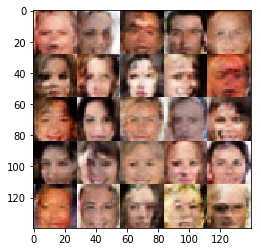

Epoch 1/1... Batch 3110... Discriminator Loss: 0.7035... Generator Loss: 1.7280
Epoch 1/1... Batch 3120... Discriminator Loss: 1.9195... Generator Loss: 4.1129
Epoch 1/1... Batch 3130... Discriminator Loss: 1.2499... Generator Loss: 0.5097
Epoch 1/1... Batch 3140... Discriminator Loss: 0.7745... Generator Loss: 1.1034
Epoch 1/1... Batch 3150... Discriminator Loss: 0.5258... Generator Loss: 1.5303
Epoch 1/1... Batch 3160... Discriminator Loss: 0.9111... Generator Loss: 0.8974


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.